
# Colinearity affects these regression types differently:
- Unregularized (OLS) regression: Most severely impacted. Colinearity leads to unstable coefficient estimates with high variance, though they remain unbiased.
- Ridge regression: Less affected than OLS. The L2 penalty stabilizes coefficients by shrinking them toward zero, reducing variance but introducing some bias. Ridge can handle colinearity better because it doesn't need to determine exact individual effects of correlated predictors.
- Lasso regression: Intermediate impact. The L1 penalty tends to select one variable from a collinear group and set others to zero, effectively performing variable selection. This can be beneficial for interpretation but may arbitrarily choose which correlated variable to retain.

The key tradeoff is between bias and variance - regularization methods (Ridge, Lasso) handle colinearity by accepting some bias to reduce variance in coefficient estimates.


- Sample size (n): Larger n reduces coefficient variance in all models
OLS becomes more stable with large n, but still affected by collinearity
Regularization becomes less necessary with very large n


- Number of variables: More variables amplify collinearity issues
Lasso tends to select fewer variables as p/n ratio increases
Ridge becomes more advantageous with high dimensionality


- Correlation magnitude: Higher correlation (>0.9) makes OLS extremely unstable
Ridge maintains relative stability even with high correlations
Lasso's variable selection becomes more arbitrary

The key insight is that these factors interact - high dimensionality with strong correlations particularly challenges OLS, while regularization methods remain more robust.


The below comparison should only be done row-wise (we need to create a new dataset every row)

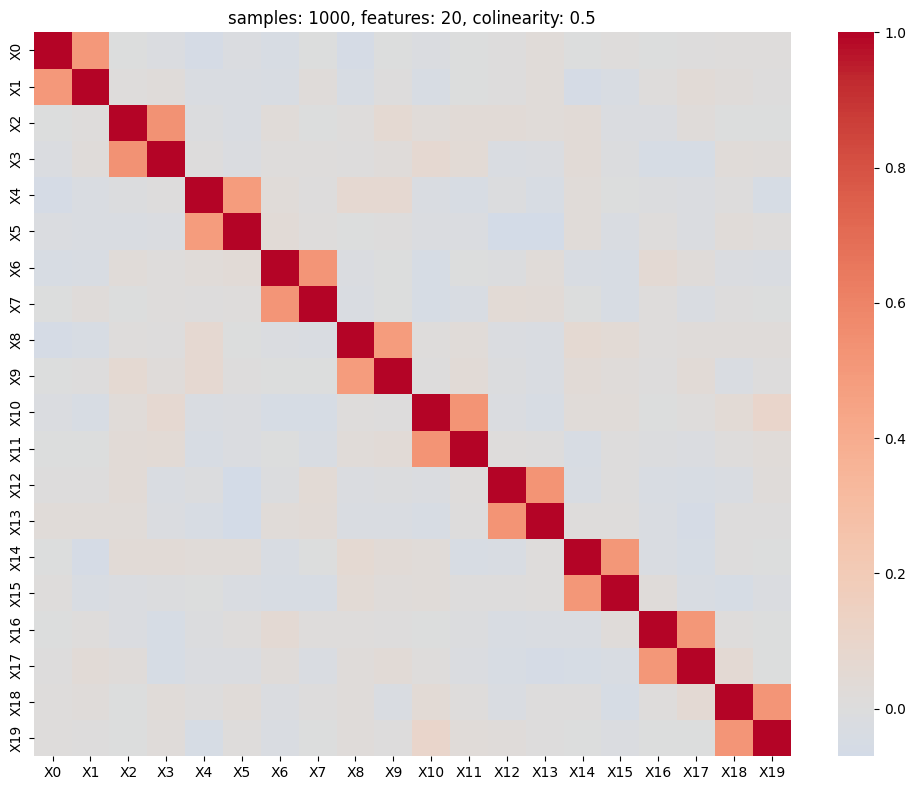

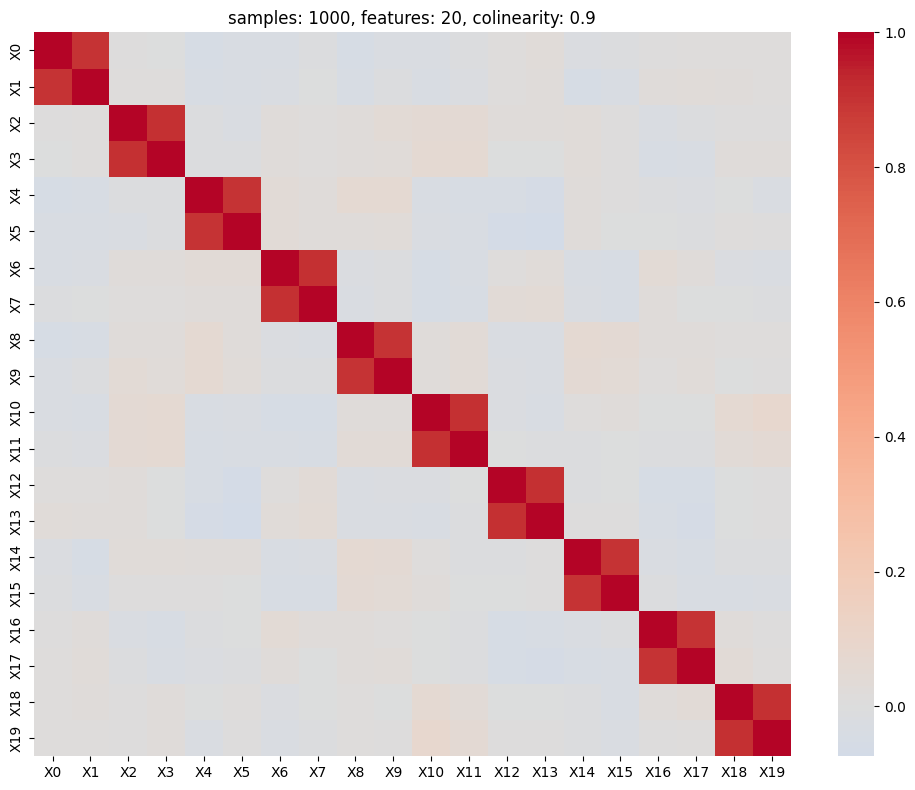

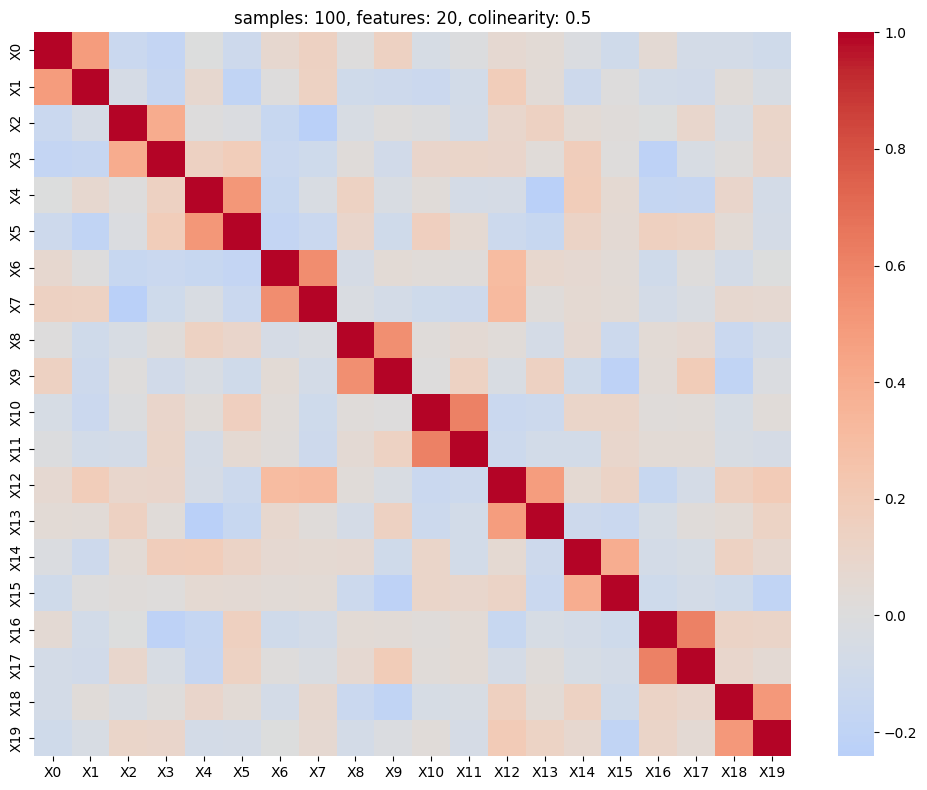

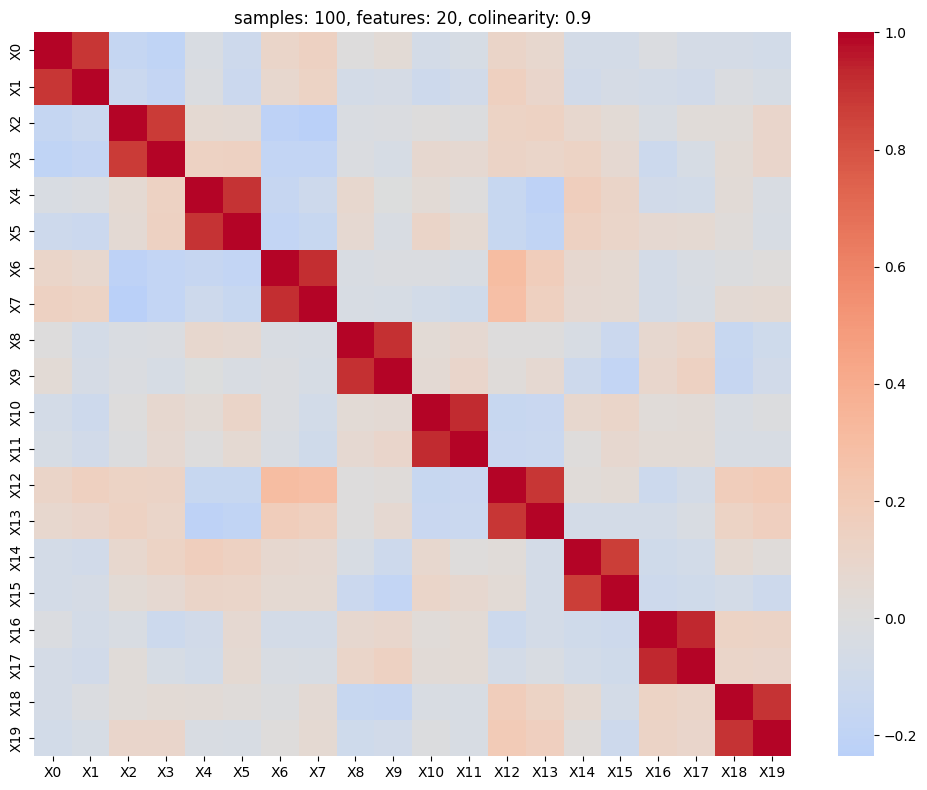


Summary Statistics:
      n  features  correlation  OLS_mae  OLS_var  Ridge_mae  Ridge_var  \
0  1000        20          0.5    0.064    0.085      0.062      0.081   
1  1000        20          0.9    0.129    0.102      0.099      0.090   
2   100        20          0.5    0.233    0.285      0.169      0.161   
3   100        20          0.9    0.508    0.593      0.136      0.172   

   Lasso_mae  Lasso_var  
0      0.061      0.061  
1      0.084      0.072  
2      0.211      0.202  
3      0.235      0.263  


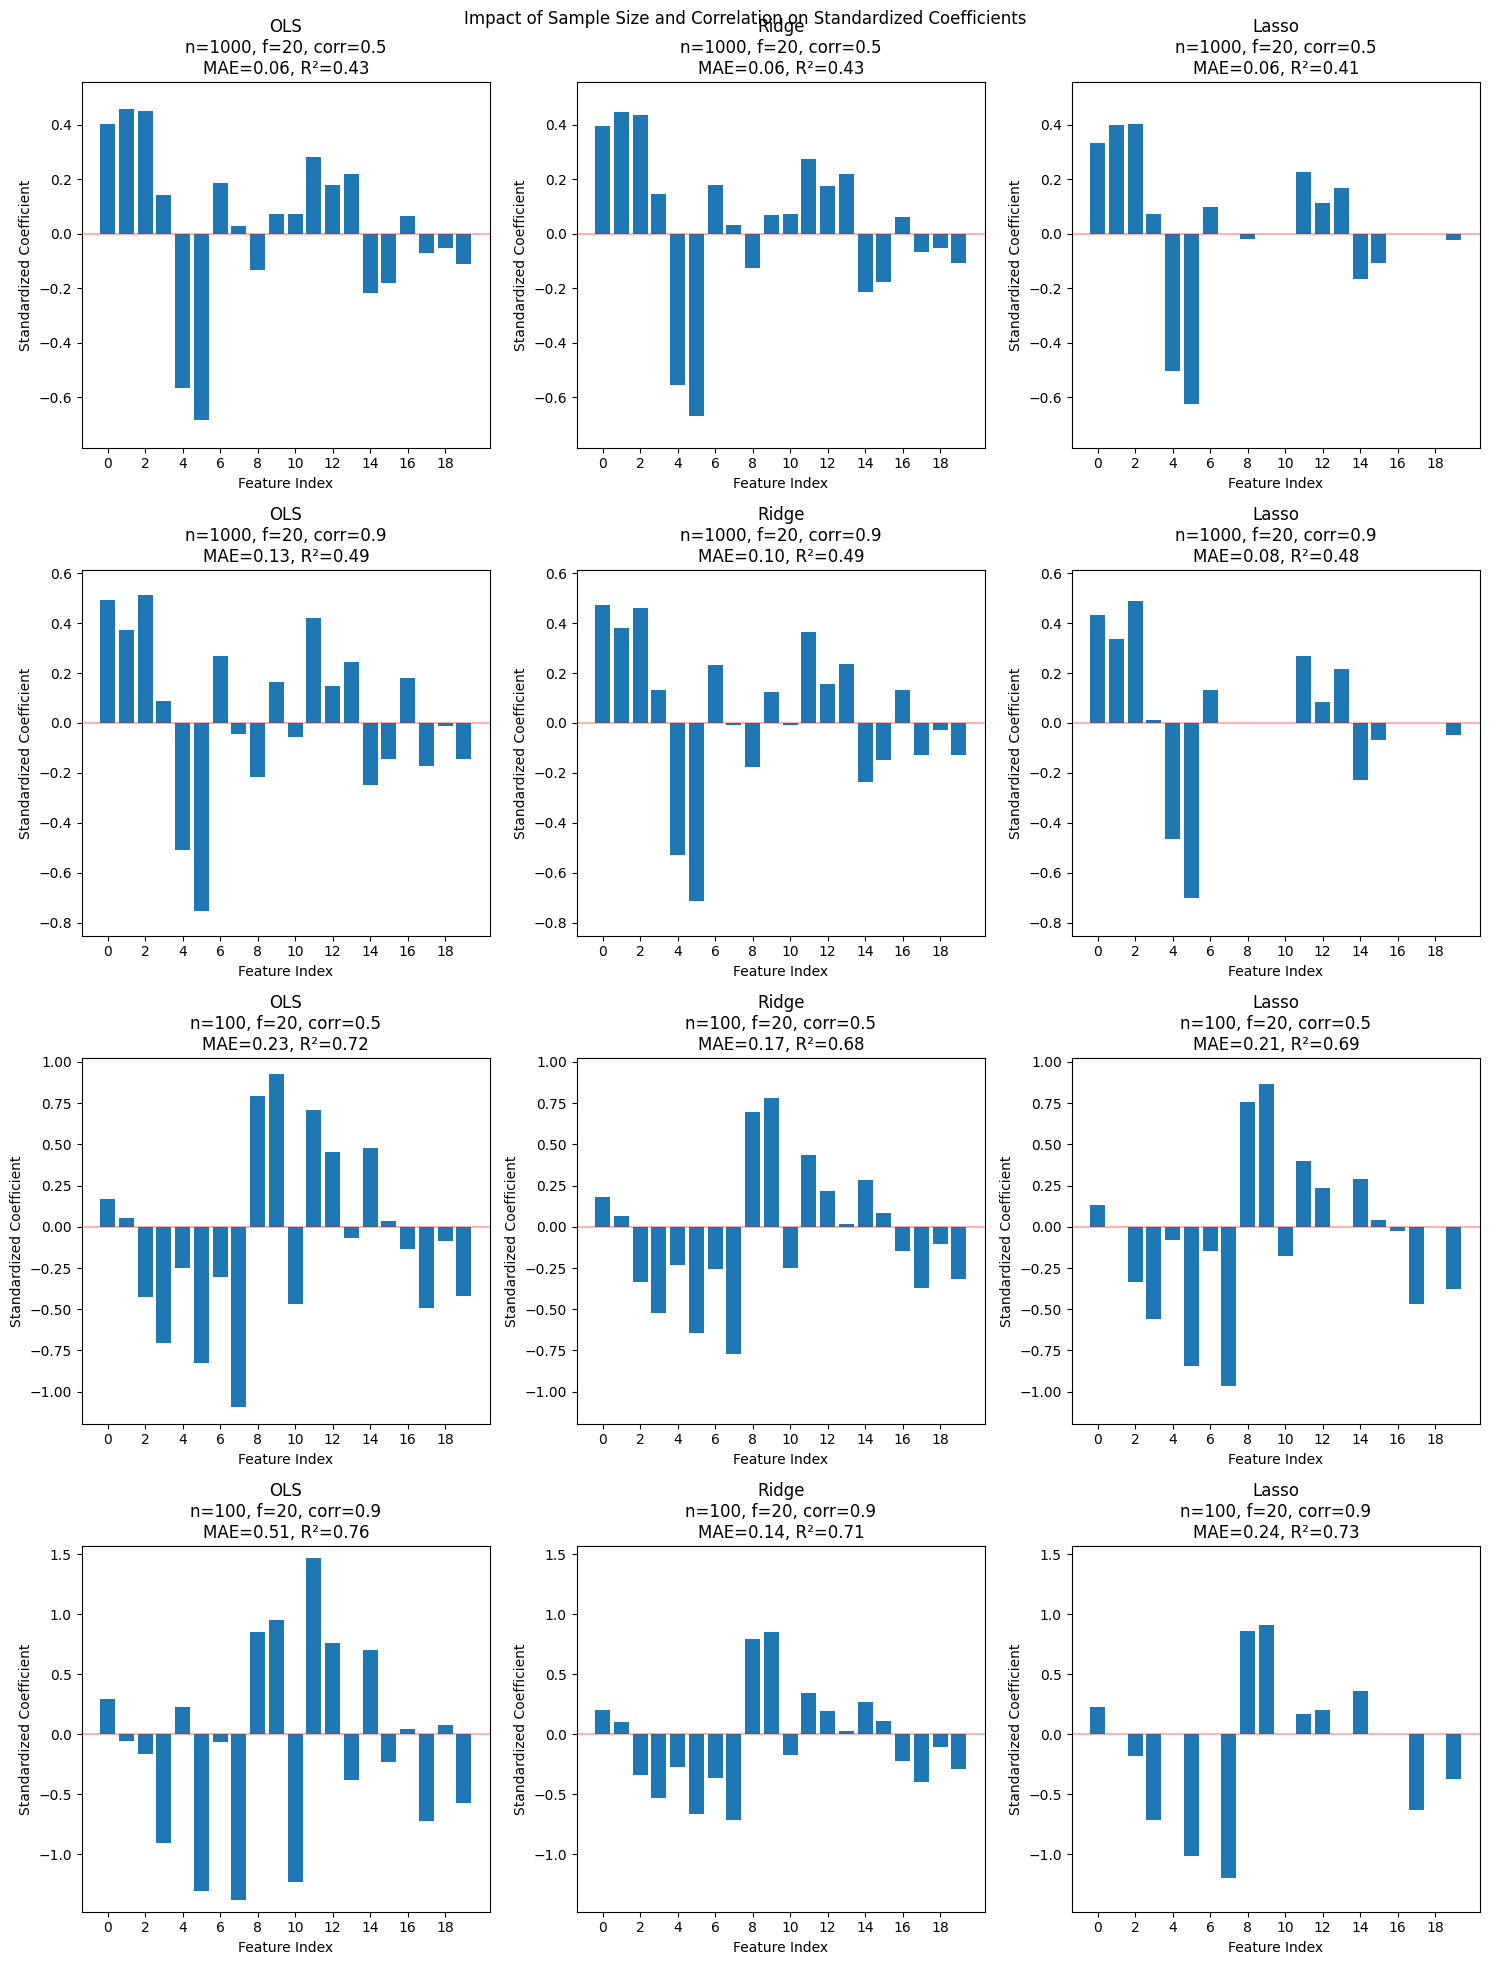

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import seaborn as sns

collinearity = 0.9

error = 1.9

# Configurations
configs = [
    (1000, 20, 0.5),    # large n, medium correlation
    (1000, 20, collinearity),   # large n, high correlation
    (100, 20, 0.5),     # small n, medium correlation
    (100, 20, collinearity),    # small n, high correlation
]

random_state = 123


def generate_correlated_features(n_samples, n_features, colinearity, random_state=random_state):
    rng = np.random.RandomState(random_state)
    correlation_matrix = np.eye(n_features)
    for i in range(0, n_features, 2):
        if i + 1 < n_features:
            correlation_matrix[i, i+1] = colinearity
            correlation_matrix[i+1, i] = colinearity
    
    X = rng.multivariate_normal(
        mean=np.zeros(n_features),
        cov=correlation_matrix,
        size=n_samples
    )
    
    true_coef = rng.normal(0, 1, n_features)
    
    for i in range(0, n_features, 2):
        if i + 1 < n_features:
            mean_coef = (true_coef[i] + true_coef[i+1]) / 2
            true_coef[i] = mean_coef + rng.normal(0, 0.1)
            true_coef[i+1] = mean_coef + rng.normal(0, 0.1)
    
    true_coef[n_features//2:] *= 0.3
    
    y = np.dot(X, true_coef) + rng.normal(0, error, n_samples)
    return X, y, true_coef

def run_experiment(n_samples, n_features, colinearity, random_state=12):
    X, y, true_coef = generate_correlated_features(n_samples, n_features, colinearity, random_state)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    models = {
        'OLS': LinearRegression(),
        'Ridge': Ridge(alpha=30, random_state=random_state),
        'Lasso': Lasso(alpha=0.1, random_state=random_state),
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_scaled, y)
        std_coef = model.coef_ * np.std(X, axis=0)
        results[name] = {
            'coef_var': np.var(std_coef),
            'r2': model.score(X_scaled, y),
            'coef': std_coef,
            'mae_true': np.mean(np.abs(std_coef - true_coef))
        }
    
    return results, true_coef, X, y



# Collect results
all_results = []
for n, f, c in configs:
    results, true_coef, X, y = run_experiment(n, f, c)
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(X.T)
    sns.heatmap(correlation_matrix, 
                xticklabels=[f'X{i}' for i in range(20)],
                yticklabels=[f'X{i}' for i in range(20)],
                cmap='coolwarm',
                center=0)
    plt.title(f'samples: {n}, features: {f}, colinearity: {c}')
    plt.tight_layout()
    plt.show()
    
    row = {'n': n, 'features': f, 'correlation': c}
    for model, metrics in results.items():
        row[f'{model}_mae'] = metrics['mae_true']
        row[f'{model}_var'] = metrics['coef_var']
    all_results.append(row)

print("\nSummary Statistics:")
print(pd.DataFrame(all_results).round(3))

# Plot coefficients
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Impact of Sample Size and Correlation on Standardized Coefficients')

for idx, (n, f, c) in enumerate(configs):
    results, true_coef, X, y = run_experiment(n, f, c)
    
    all_coefs = np.concatenate([metrics['coef'] for metrics in results.values()])
    y_min, y_max = np.min(all_coefs), np.max(all_coefs)
    
    for midx, (model_name, metrics) in enumerate(results.items()):
        ax = axes[idx, midx]
        coefs = metrics['coef']
        
        ax.bar(range(len(coefs)), coefs)
        ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        ax.set_title(f'{model_name}\nn={n}, f={f}, corr={c}\nMAE={metrics["mae_true"]:.2f}, R²={metrics["r2"]:.2f}')
        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Standardized Coefficient')
        ax.set_ylim(y_min-0.1, y_max+0.1)
        ax.set_xticks(range(0, len(coefs), 2))

plt.tight_layout()
plt.show()

The key row is the second row where we have high collinearity between every two variables (0 and 1, 2 and 3, etc.). LASSO often reduces one of them to zero or close to zero (12 from 12 and 13). This doesnt make sense because they are correlated at 0.9, they are basically the same variable. 

# With small samples (bottom rows), you often see opposite coefficients for variables that are correlated
It's the nature of small samples with collinearity. With n=100, there's higher variance in coefficient estimates, and regularization (Ridge/Lasso) may not fully stabilize them. The opposite coefficients appear because the model struggles to distinguish individual effects of correlated features when data is limited.

demonstrate this by running multiple trials with n=100 to show how coefficient estimates vary across runs

In [23]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge

def analyze_coefficient_stability(n_samples, n_features=20, colinearity=0.85, n_trials=100, base_seed=12):
    all_coefs = {'OLS': [], 'Ridge': [], 'Lasso': []}
    
    for trial in range(n_trials):
        X, y, true_coef = generate_correlated_features(n_samples, n_features, colinearity, random_state=base_seed+trial)
        corr_matrix = np.corrcoef(X.T)
        X_scaled = StandardScaler().fit_transform(X)
        
        for name, model in [('OLS', LinearRegression()), 
                          ('Ridge', Ridge(alpha=30, random_state=base_seed)), 
                          ('Lasso', Lasso(alpha=0.1, random_state=base_seed))]:
            model.fit(X_scaled, y)
            all_coefs[name].append(model.coef_)
    
    all_coefs = {k: np.array(v) for k, v in all_coefs.items()}
    
    metrics = {}
    for name, coefs in all_coefs.items():
        metrics[name] = {
            'mean_var': np.mean([np.var(coefs[:, i:i+2]) 
                               for i in range(0, n_features, 2) if i+1 < n_features]),
            'sign_flips': np.mean([np.sum(np.sign(coefs[:, i]) != np.sign(coefs[:, i+1])) / n_trials
                                 for i in range(0, n_features, 2) if i+1 < n_features])
        }
    
    return all_coefs, true_coef, corr_matrix, metrics



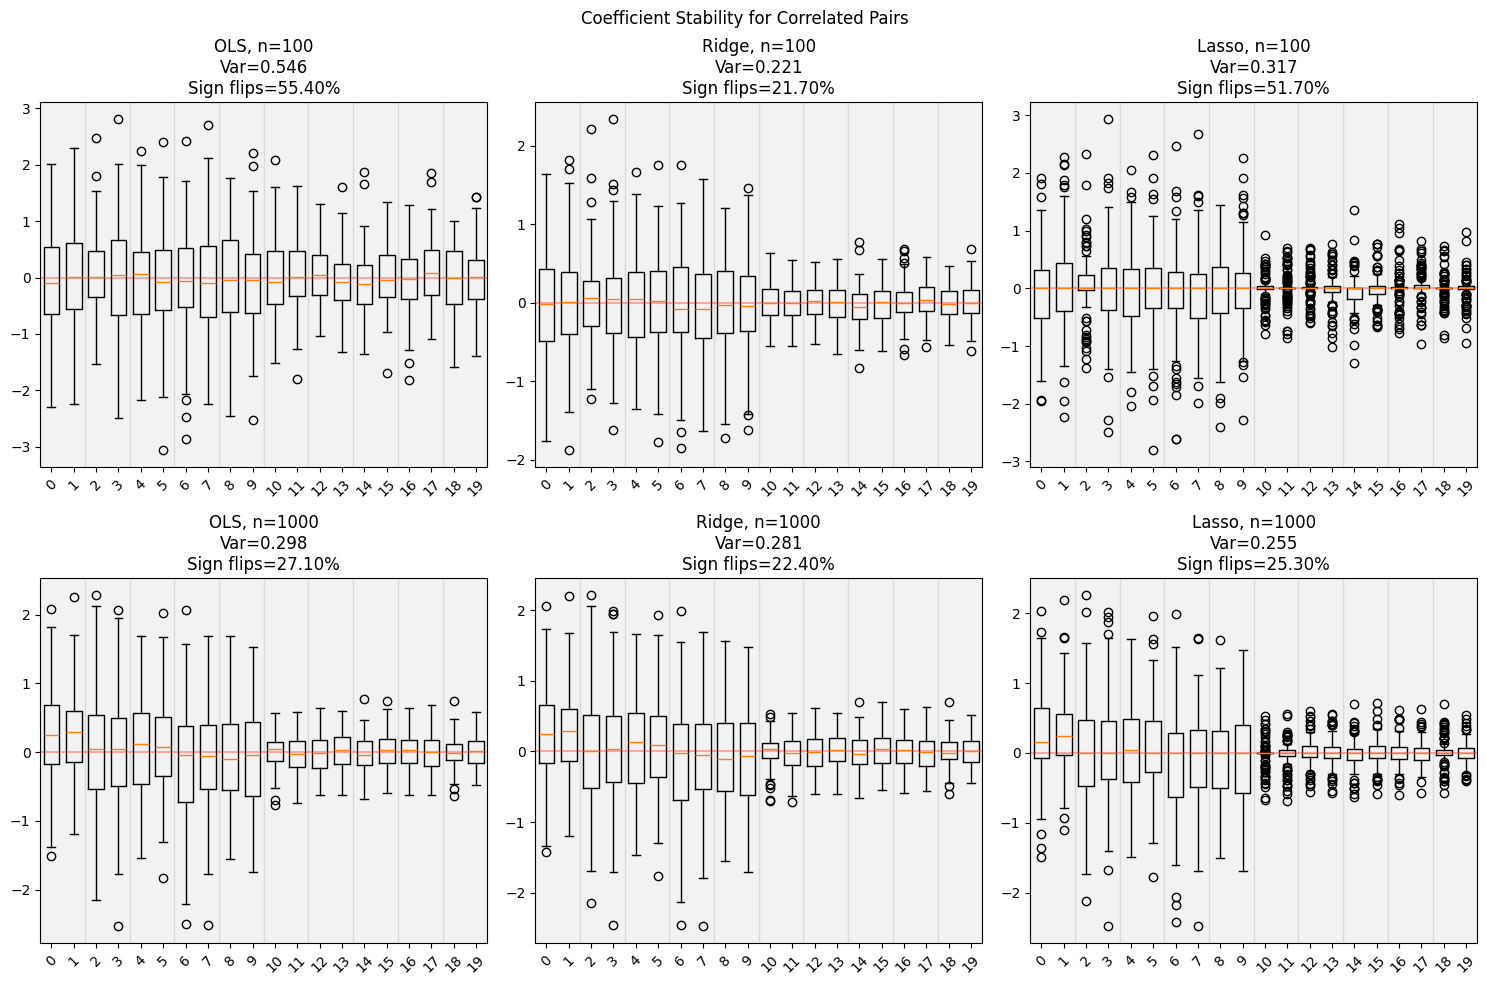

In [24]:
# Run experiments
np.random.seed(12)

colinearity = 0.9

sample_sizes = [100, 1000]
results = {n: analyze_coefficient_stability(n, colinearity=colinearity) for n in sample_sizes}

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Coefficient Stability for Correlated Pairs')

for row, n in enumerate(sample_sizes):
    coefs, true_coef, corr_matrix, metrics = results[n]
    
    for col, (model_name, model_coefs) in enumerate(coefs.items()):
        ax = axes[row, col]
        
        positions = []
        labels = []
        coef_pairs = []
        
        for i in range(0, 20, 2):
            if i + 1 < 20:
                positions.extend([i+0.5, i+1.5])
                labels.extend([f'{i}', f'{i+1}'])
                coef_pairs.extend([model_coefs[:, i], model_coefs[:, i+1]])
        
        bp = ax.boxplot(coef_pairs, positions=positions, widths=0.7)
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=45)
        
        ax.set_title(f'{model_name}, n={n}\nVar={metrics[model_name]["mean_var"]:.3f}\nSign flips={metrics[model_name]["sign_flips"]:.2%}')
        ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        
        for i in range(0, len(positions), 2):
            ax.axvspan(positions[i]-0.5, positions[i+1]+0.5, 
                      color='gray', alpha=0.1)

plt.tight_layout()
plt.show()

# Collinearity 0.5


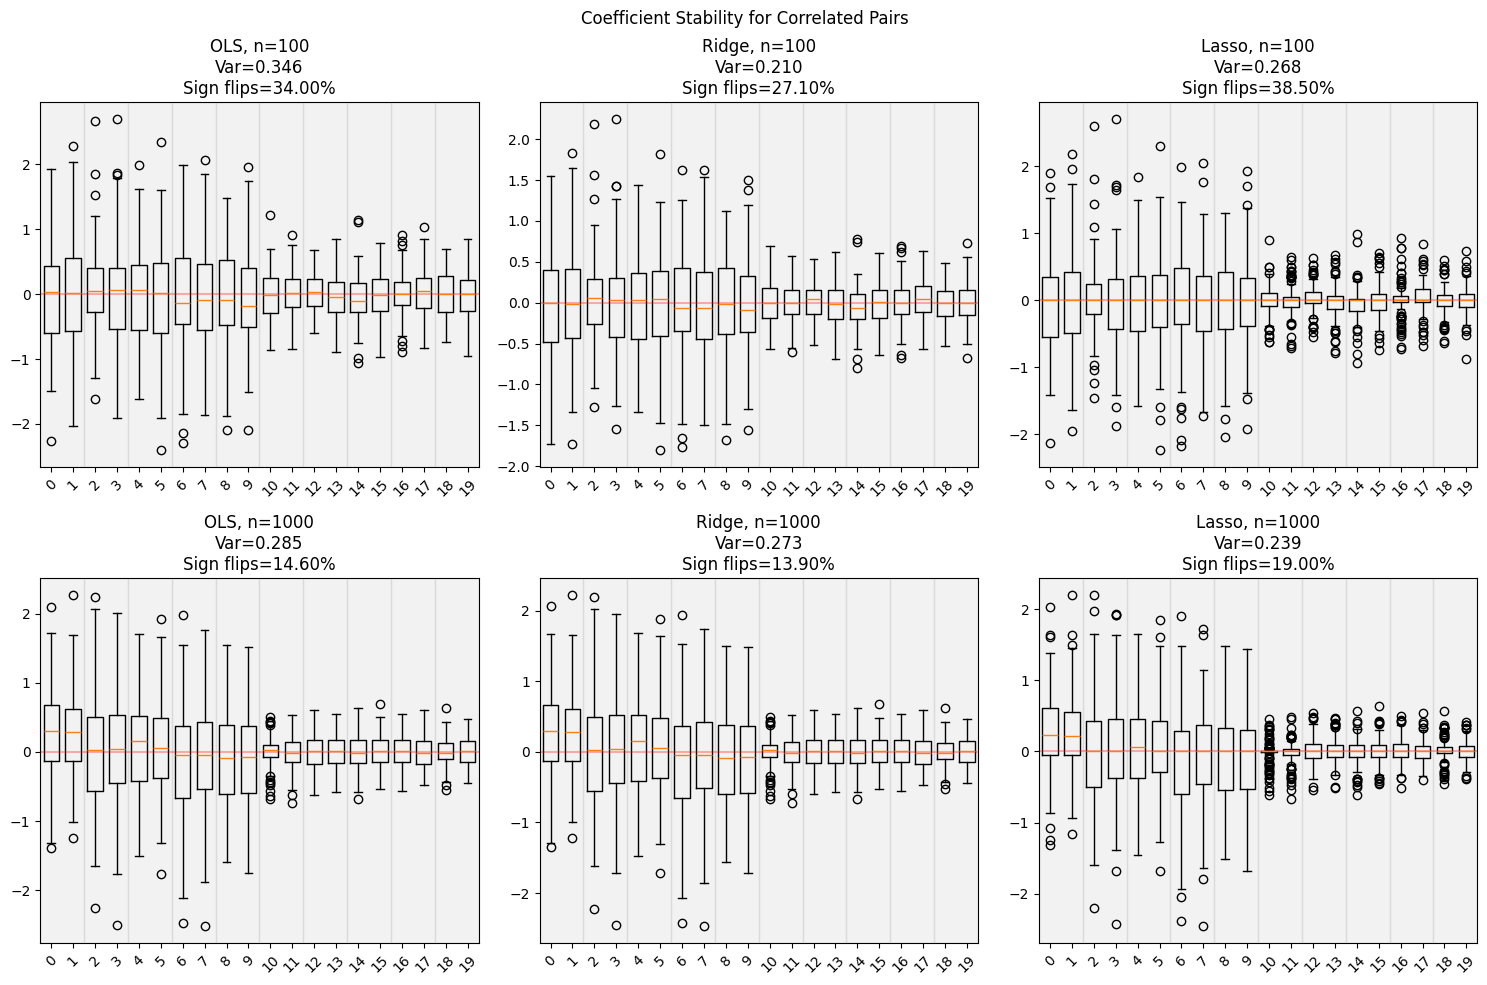

In [25]:
# Run experiments
np.random.seed(12)

colinearity = 0.5

sample_sizes = [100, 1000]
results = {n: analyze_coefficient_stability(n, colinearity=colinearity) for n in sample_sizes}

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Coefficient Stability for Correlated Pairs')

for row, n in enumerate(sample_sizes):
    coefs, true_coef, corr_matrix, metrics = results[n]
    
    for col, (model_name, model_coefs) in enumerate(coefs.items()):
        ax = axes[row, col]
        
        positions = []
        labels = []
        coef_pairs = []
        
        for i in range(0, 20, 2):
            if i + 1 < 20:
                positions.extend([i+0.5, i+1.5])
                labels.extend([f'{i}', f'{i+1}'])
                coef_pairs.extend([model_coefs[:, i], model_coefs[:, i+1]])
        
        bp = ax.boxplot(coef_pairs, positions=positions, widths=0.7)
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=45)
        
        ax.set_title(f'{model_name}, n={n}\nVar={metrics[model_name]["mean_var"]:.3f}\nSign flips={metrics[model_name]["sign_flips"]:.2%}')
        ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        
        for i in range(0, len(positions), 2):
            ax.axvspan(positions[i]-0.5, positions[i+1]+0.5, 
                      color='gray', alpha=0.1)

plt.tight_layout()
plt.show()

# Conclusion

- Small ridge is similar to OLS. 
- Above 20-30, it starts being different. 
- Ridge is the best at returning coefficients that would be the same sign over multiple iterations (flips sign less): 27% vs 39%
- Lasso reduces many coefficients to zero even when they are almost identical to other features.
- It is rare to have features correlate at 0.9 or more. If they do, just remove one of the two.
- You can always compare. 
- And you can bootstrap.
